In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(150,150,3))
conv_base.summary()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [2]:
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# First using a numpy array to save the output from conv_base then using the array as an input for a DNN model (least expensive but can't use data augmentation in it)

In [3]:
base_dir = 'C://Users/Ahmed/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        batch_size=batch_size,
        target_size=(150,150),
        class_mode = 'binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    
    return features,labels

train_features, train_labels = extract_features(train_dir,2000)
val_features, val_labels = extract_features(validation_dir,1000)
test_features, test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))
val_features = np.reshape(val_features, (1000, 4*4*512))

model= models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=8192))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=batch_size,
                   validation_data=(val_features,val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6413 - acc: 0.6445 - val_loss: 0.4287 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.4214 - acc: 0.8105 - val_loss: 0.3470 - val_acc: 0.8770
Epoch 3/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3439 - acc: 0.8520 - val_loss: 0.3130 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3112 - acc: 0.8680 - val_loss: 0.2958 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2829 - acc: 0.8855 - val_loss: 0.2748 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2598 - acc: 0.8945 - val_loss: 0.2657 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2421 - acc: 0.9060 - val_loss: 0.2638 - val_acc: 0.8870
Epoch 8/30
200

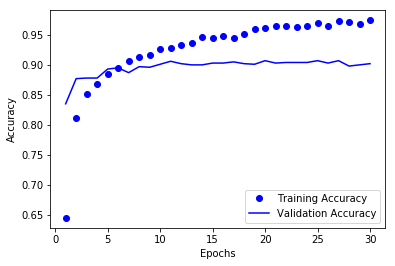

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

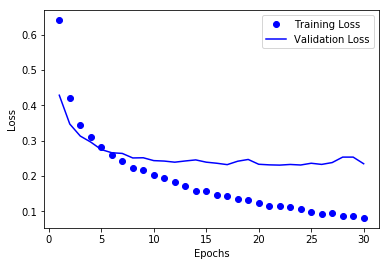

In [10]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Making a full convNet model using conv_base as first layer (very expensive but can use data augmentation in it)

In [5]:
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_datagenerator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

val_datagenerator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_datagenerator, steps_per_epoch=100, epochs=30, 
                              validation_data=val_datagenerator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 36/100 [=========>....................] - ETA: 6:59 - loss: 0.6607 - acc: 0.5931

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Using fine tuning

In [12]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else :
        layer.trainable = False
        
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_datagenerator, steps_per_epoch=100, epochs=30, 
                              validation_data=val_datagenerator, validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()